In [6]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/planar_quad_lqr/Project.toml`
Precompiling project...
  ✓ AssetRegistry
  ✓ Conda
  ✓ HTTP
  ✓ WebSockets
  ✓ Mux
  ✓ WebIO
  ✓ JSExpr
  ✓ PyCall
  ✓ Blink
  ✓ PyPlot
  ✓ MeshCat
  11 dependencies successfully precompiled in 12 seconds (123 already precompiled)
  3 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [11]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using ControlSystems
using MeshCat
using RobotZoo: Quadrotor, PlanarQuadrotor
using CoordinateTransformations, Rotations, Colors, StaticArrays, RobotDynamics

In [85]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters
J = 0.2*m*ℓ*ℓ

#Thrust limits
umin = [0.2*m*g; 0.2*m*g]
umax = [0.6*m*g; 0.6*m*g]

h = 0.1 #time step (20 Hz)

0.1

In [105]:
0.2*m*ℓ*ℓ

0.018

In [86]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/J)*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

quad_dynamics (generic function with 1 method)

In [87]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

quad_dynamics_rk4 (generic function with 1 method)

In [88]:
#Linearized dynamics for hovering
x_hover = zeros(6)
u_hover = [0.5*m*g; 0.5*m*g]
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,u_hover),x_hover);
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x_hover,u),u_hover);
quad_dynamics_rk4(x_hover, u_hover)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [89]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 6.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [108]:
Nt

61

In [91]:
# Cost weights
Q = Array(1.0*I(Nx));
R = Array(.01*I(Nu));
Qn = Array(1.0*I(Nx));

In [92]:
#Cost function
function cost(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(size(xhist,2)-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

cost (generic function with 1 method)

In [93]:
#LQR Hover Controller
P = dare(A,B,Q,R)
K = dlqr(A,B,Q,R)

function lqr_controller(t,x,K,xref)
    
    return u_hover - K*(x-xref)
end

lqr_controller (generic function with 1 method)

In [115]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        # xhist[:,k+1] .= quad_dynamics_rk4(xhist[:,k],uhist[:,k])
        xhist[:,k+1] .= A*xhist[:,k]+B*(uhist[:,k]-u_hover)
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [116]:
x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [2.0; 2.0; 0.0; 0; 0; 0]
xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
# xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,x_ref), Nt);

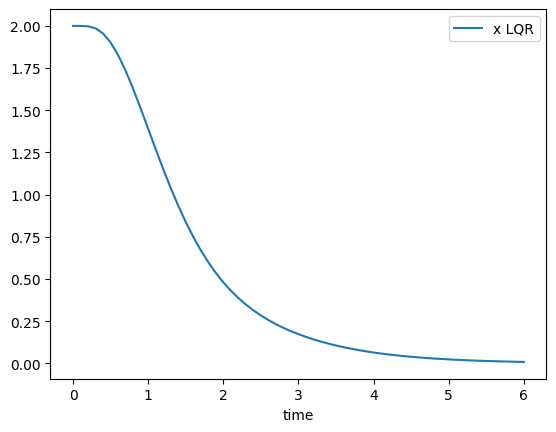

PyObject <matplotlib.legend.Legend object at 0x7fd508aa2650>

In [117]:
plot(thist,xhist1[1,:], label="x LQR")
# plot(thist,xhist2[1,:], label="x MPC")
xlabel("time")
legend()

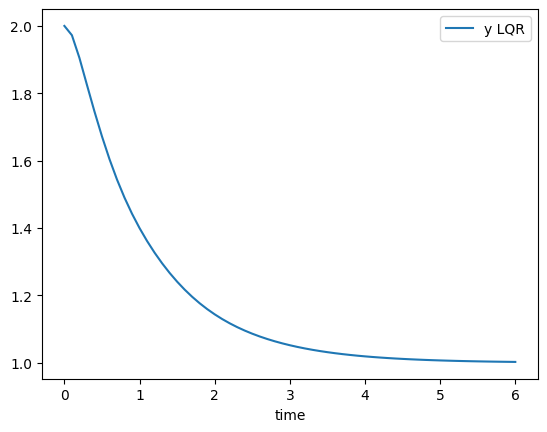

PyObject <matplotlib.legend.Legend object at 0x7fd509561cd0>

In [97]:
plot(thist,xhist1[2,:], label="y LQR")
# plot(thist,xhist2[2,:], label="y MPC")
xlabel("time")
legend()

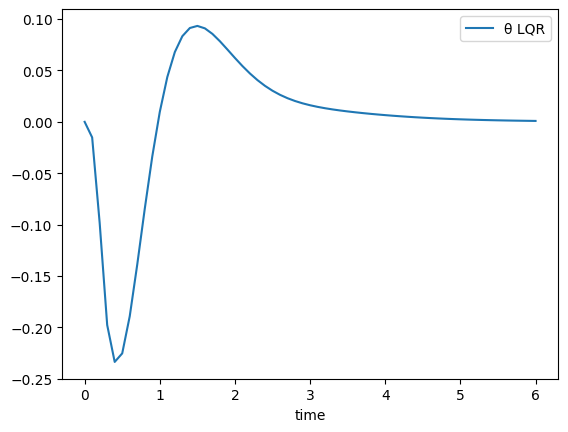

PyObject <matplotlib.legend.Legend object at 0x7fd5094e5c10>

In [98]:
plot(thist,xhist1[3,:], label="θ LQR")
# plot(thist,xhist2[3,:], label="θ MPC")
xlabel("time")
legend()

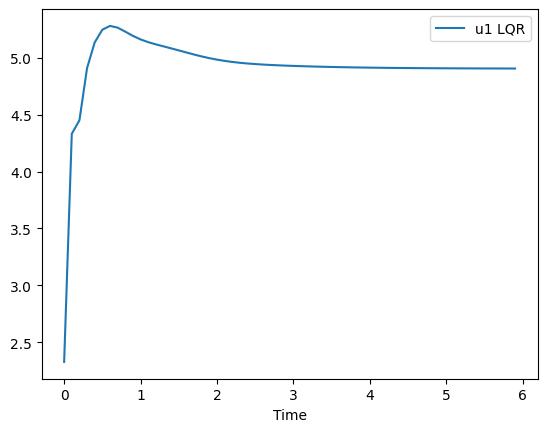

PyObject <matplotlib.legend.Legend object at 0x7fd50947e710>

In [99]:
plot(thist[1:end-1], uhist1[1,:], label="u1 LQR")
# plot(thist[1:end-1], uhist2[1,:], label="u1 MPC")
xlabel("Time")
legend()

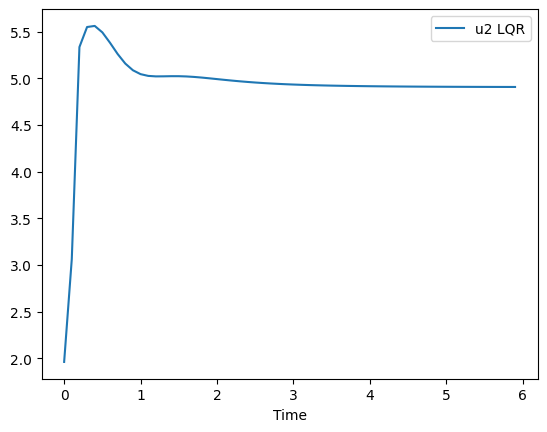

PyObject <matplotlib.legend.Legend object at 0x7fd50940d690>

In [100]:
plot(thist[1:end-1], uhist1[2,:], label="u2 LQR")
# plot(thist[1:end-1], uhist2[2,:], label="u2 MPC")
xlabel("Time")
legend()

In [101]:
#Set up visualization
function set_mesh!(vis, model::L;
        scaling=1.0, color=colorant"black"
    ) where {L <: Union{Quadrotor, PlanarQuadrotor}} 
    # urdf_folder = joinpath(@__DIR__, "..", "data", "meshes")
    urdf_folder = @__DIR__
    # if scaling != 1.0
    #     quad_scaling = 0.085 * scaling
    obj = joinpath(urdf_folder, "quadrotor_scaled.obj")
    if scaling != 1.0
        error("Scaling not implemented after switching to MeshCat 0.12")
    end
    robot_obj = MeshFileGeometry(obj)
    mat = MeshPhongMaterial(color=color)
    setobject!(vis["robot"]["geom"], robot_obj, mat)
    if hasfield(L, :ned)
        model.ned && settransform!(vis["robot"]["geom"], LinearMap(RotX(pi)))
    end
end

function visualize!(vis, model::PlanarQuadrotor, x::StaticVector)
    py,pz = x[1], x[2]
    θ = x[3]
    settransform!(vis["robot"], compose(Translation(0,py,pz), LinearMap(RotX(-θ))))
end

function visualize!(vis, model, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{6}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [102]:
vis = Visualizer()
model = PlanarQuadrotor()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8708
└ @ MeshCat /home/khai/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8708))

In [103]:
X1 = [SVector{6}(x) for x in eachcol(xhist1)];
# X2 = [SVector{6}(x) for x in eachcol(xhist2)];

In [104]:
visualize!(vis, model, thist[end], X1)